In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/abraham-pc/Documents/paid_gigs/malaria_prediction_cv'

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import numpy as np
import joblib

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


2024-01-19 08:14:08.669340: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 08:14:08.817415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 08:14:08.817525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 08:14:08.838444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 08:14:08.893525: I tensorflow/core/platform/cpu_feature_guar

In [3]:
def configure_gpu():

    try:
        gpus = tf.config.list_physical_devices('GPU')
        print(f"Found {len(gpus)} GPU(s): {gpus}")
    except Exception as e:
        print("Error configuring GPU: \n", e)
        print("Training will run on CPU")

    if gpus: # type: ignore
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth enabled for all Physical GPUs")
        except Exception as e:
            print("Error configuring memory growth: \n", e)

configure_gpu()

Found 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth enabled for all Physical GPUs


2024-01-19 08:14:47.698490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 08:14:47.783897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 08:14:47.784160: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [71]:
model_name = 'exp9_4_SA_512'
test_model_file = f'./models/checkpoints/{model_name}'

test_model = tf.keras.models.load_model(test_model_file, custom_objects={"f1_score": tfa.metrics.F1Score(num_classes=4)})
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [5]:
from src.features.build_features import X_test, y_test, test_df, transform_data

In [6]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
encoder = joblib.load('./src/features/encoder.joblib')
species = ['Falciparum', 'Malariae', 'Ovale', 'Vivax']
mapping = dict(zip([index for index in range(4)], species))

1/1 [==============================] - 0s 82ms/step
Predicted: Vivax 
 Actual: Vivax


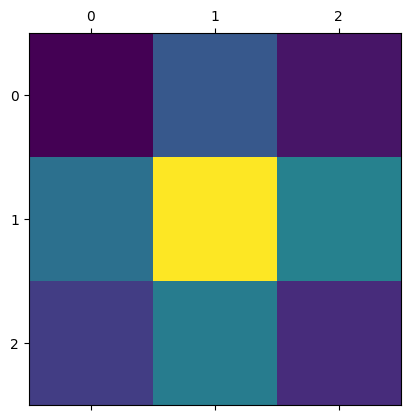

In [72]:
# Prepare image
idx = 2
img_array = transform_data(X_test)

# Make model
model = test_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(np.array(img_array[idx]).reshape(-1, 224, 224, 3))
actual = mapping[np.argmax(y_test[0])]
print("Predicted:", mapping[np.argmax(preds[0])], "\n", "Actual:", actual)

# Generate class activation heatmap
last_conv_layer_name = "conv2d_1"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.savefig(f"./models/grad_cam/cam_heatmap_{model_name}.jpg")
plt.show()


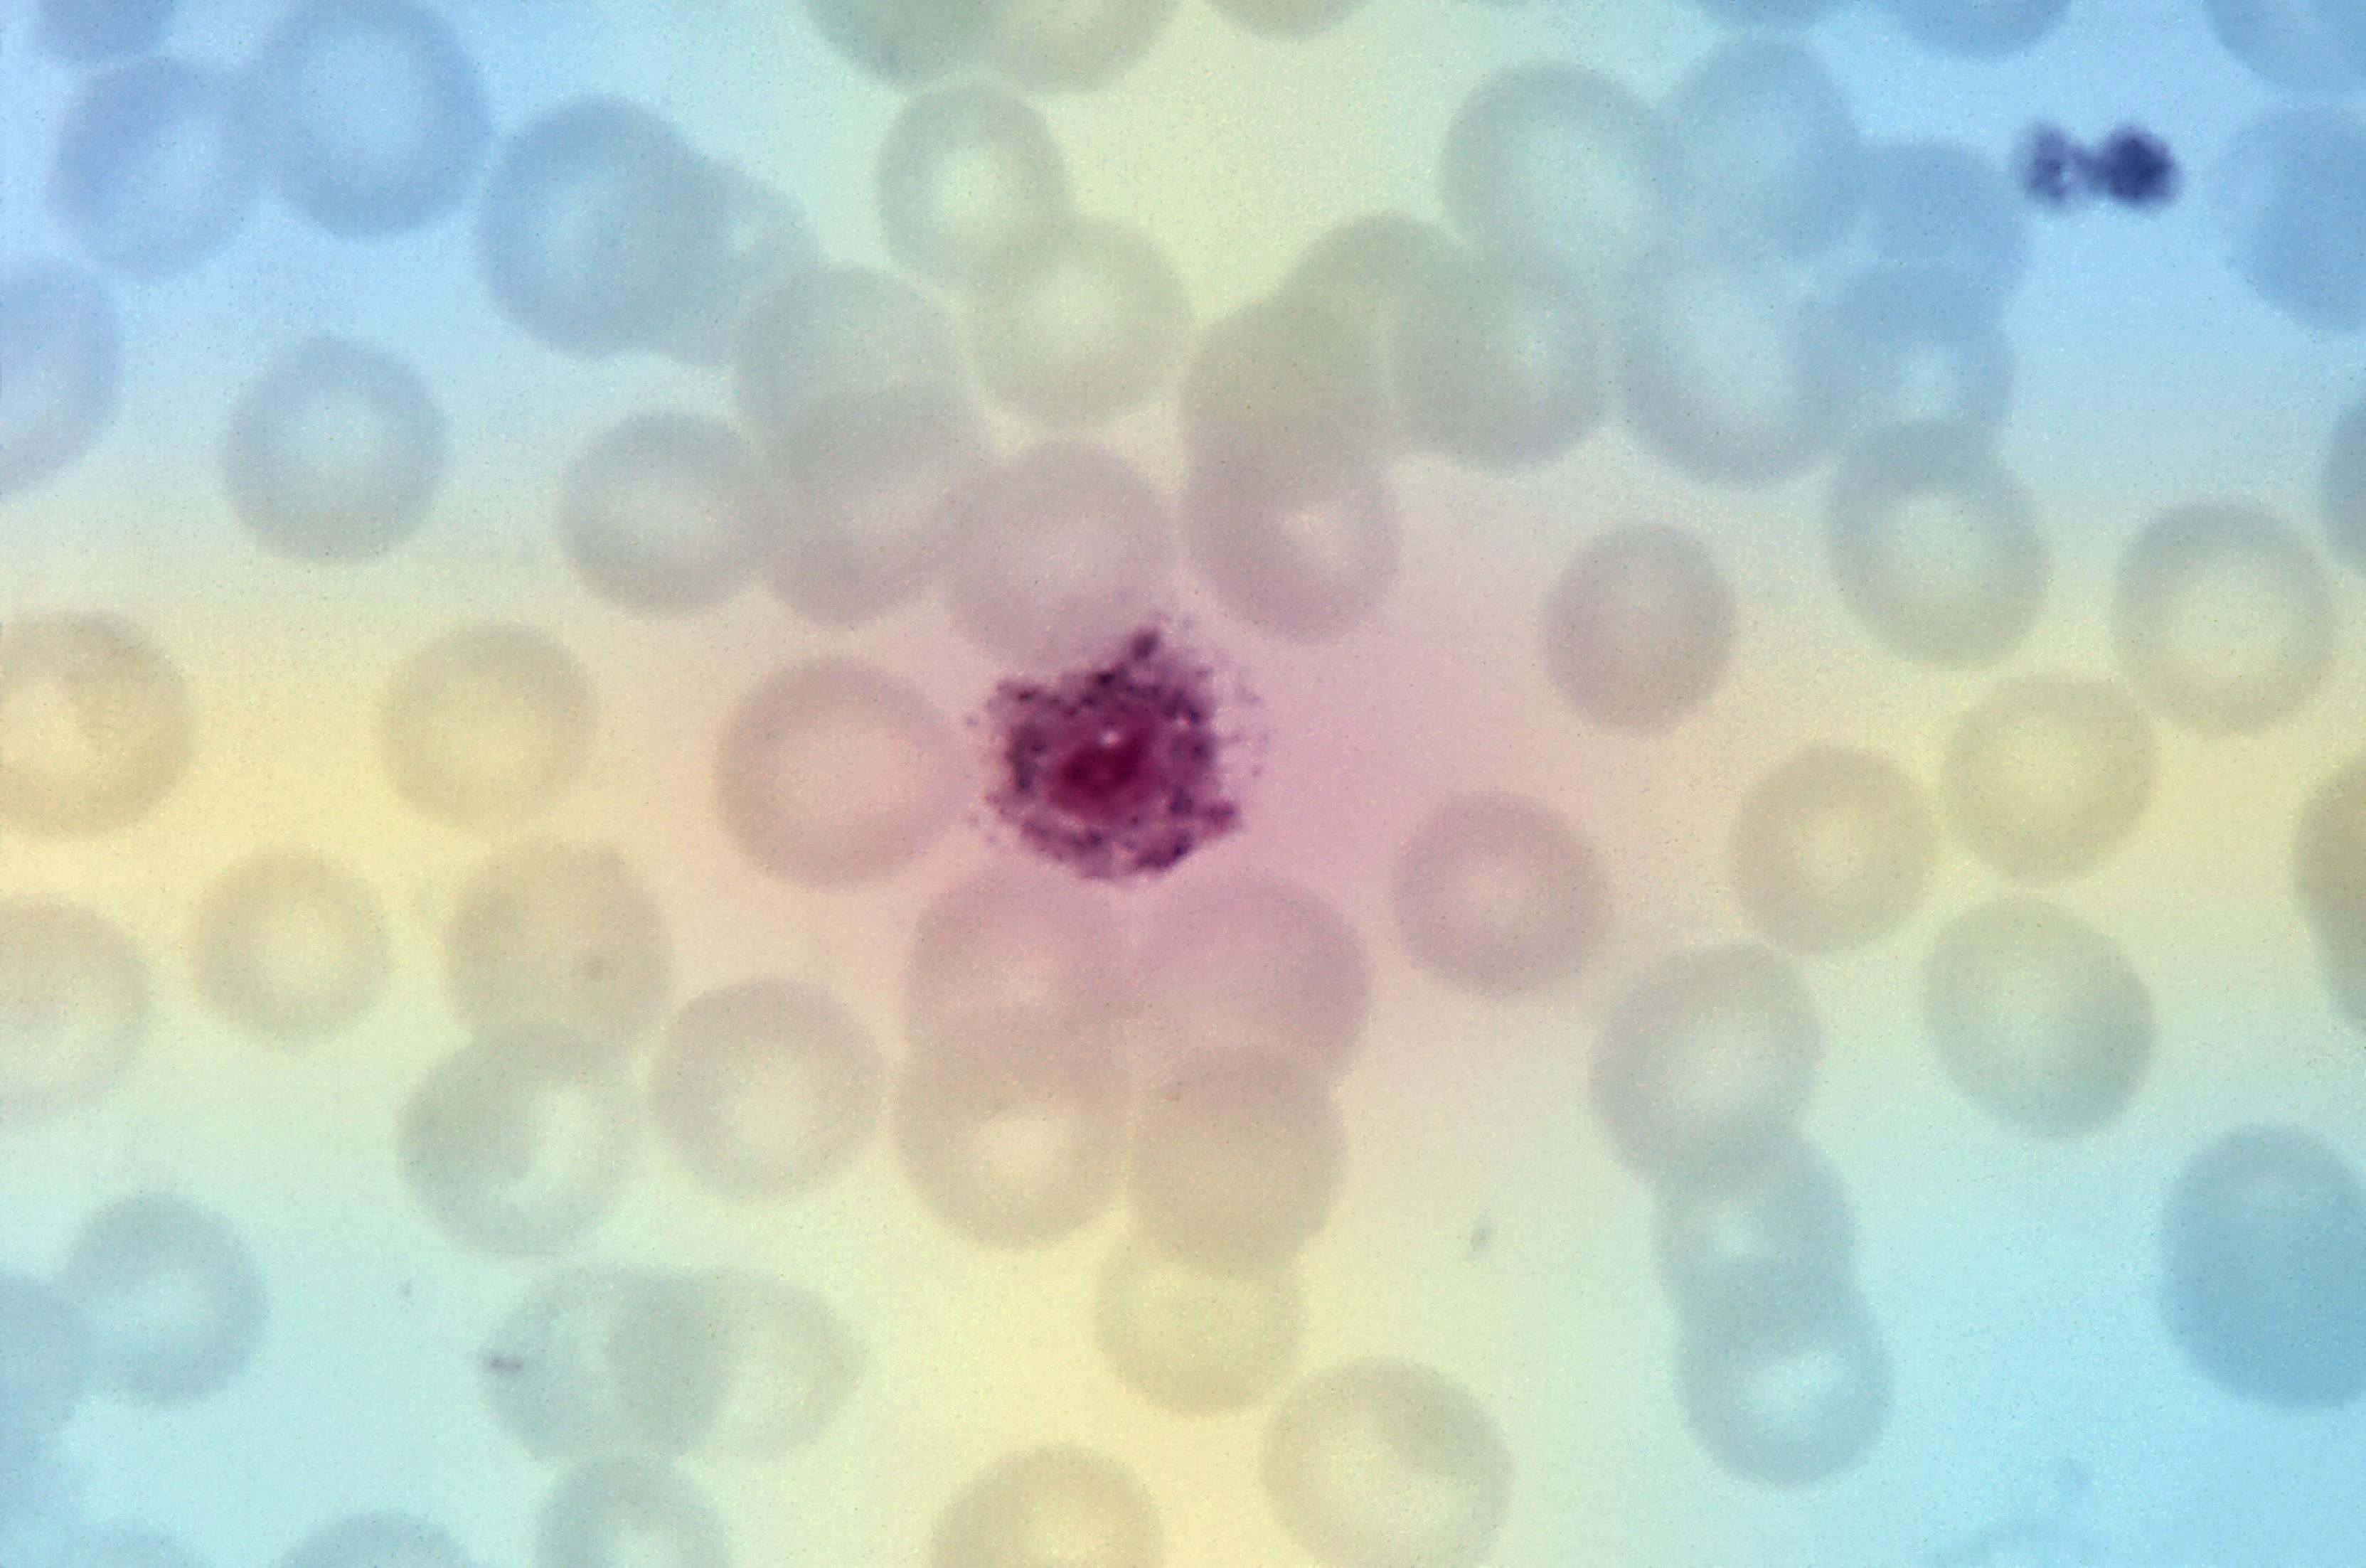

In [55]:
def save_and_display_gradcam(img_path, heatmap, cam_path=f"./models/grad_cam/cam_{model_name}.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

img_path = test_df['image'].iloc[idx]
save_and_display_gradcam(img_path, heatmap)
